### Part 0: Determining PVs of Interest

Not observing: 
- ACCL
- anything starting with V
- YAGS

Observing: 
TORO (gives us an idea about the charge of the particle)
XCOR, YCOR (dipole correctors in specific directions)
BPM
BPMS: HTR
BPMS: L0B

In order: 
1. SOLN:GUNB:100:BACT
2. QUAD:GUNB:212:1:BACT
3. SOLN:GUNB:212:BACT
4. QUAD:GUNB:212:2:BACT
5. XCOR:GUNB:293:BACT
6. YCOR:GUNB:293:BACT
7. BPMS:GUNB:314:X, BPMS:GUNB:314:Y
8. TORO:GUNB:360:CHRG
9. XCOR:GUNB:388:BACT
10. YCOR:GUNB:388:BACT
11. XCOR:GUNB:513:BACT
12. YCOR:GUNB:513:BACT
13. XCOR:GUNB:713:BACT
14. YCOR:GUNB:713:BACT
15. QUAD:GUNB:823:1:BACT
16. SOLN:GUNB:823:BACT
17. QUAD:GUNB:823:2:BACT
18. BPMS:GUNB:925:X, BPMS:GUNB:925:Y
19. XCOR:GUNB:927:BACT
20. YCOR:GUNB:927:BACT
21. BPMS:L0B:0183:X_SLOW, BPMS:L0B:0183:Y_SLOW
22. BPMS:HTR:120:X_SLOW, BPMS:HTR:120:Y_SLOW


### Part 1: Test Plotting Raw Data From ArchViewer

Step 1: Start by looking at the data for a small timeframe using the PV "SOLN:GUNB:100"
- test 1 minute vs 5 minutes vs 15 minutes to see if there are timeframe gaps or if all the data is actually saved

Step 2: Clean the data if necessary, save in a function

Step 3: Visualize with matplotlib, save in a function

Step 4: Develop a filtering function that only analyzes the peaks and returns timestamps for the max and the width of the peak

In [23]:
import numpy as np
import pandas as pd
import datetime
import re

In [24]:
# get average length of non-NA data points of each 1m interval for the 1m, 1h, and 1d csv files 

soln_gunb_100_df_1m = pd.read_csv("1m-soln-gunb-100.csv")
soln_gunb_100_df_5m = pd.read_csv("5m-soln-gunb-100.csv")
soln_gunb_100_df_15m = pd.read_csv("15m-soln-gunb-100.csv")

"""for a df, for every column, get its length, ignoring the NA cells, and return the average length""" 
def get_length_avg_no_NA(df_name): 
    col_sum = 0
    for column_name in df_name: 
        col_length = len(df_name[column_name].dropna())
        col_sum += col_length
    return col_sum / len(df_name.columns)

# return values

print(f"Length of 1m column: {get_length_avg_no_NA(soln_gunb_100_df_1m)}")
print(f"Length of 5m column: {get_length_avg_no_NA(soln_gunb_100_df_5m)}")
print(f"Length of 15m column: {get_length_avg_no_NA(soln_gunb_100_df_15m)}")

Length of 1m column: 10.525
Length of 5m column: 40.975
Length of 15m column: 231.2


In conclusion, this roughly scales linearly, so it's not like the ArchViewer is hiding data for larger timestamps. 

It was discovered that when you save data, a good chunk of it is taken from a completely different day. So the best way to deal with this issue is to get the first several characters, get the most common date (since we only care about a single day), and filter out the undesired rows. 

Of course, this is only relevant when looking at small time frames.

In [25]:
# test filtering out irrelevant dates using the 1m df 

soln_gunb_100_df_1m["Timestamp"][0][0:10]

test_timestamp_list = soln_gunb_100_df_1m["Timestamp"].tolist()
date_only_list = [x[0:10] for x in test_timestamp_list] # list with only dates

from collections import Counter
date_counts_dict = Counter(date_only_list)
common_date = date_counts_dict.most_common(1)[0][0] # get the most common date

# only get rows that have the common date 

common_date_only_list = [x if x == common_date else None for x in date_only_list]
none_length = len([x for x in common_date_only_list if x == None])
filtered_soln_gunb_100_df_1m = soln_gunb_100_df_1m.iloc[none_length:, 0:]

filtered_soln_gunb_100_df_1m.head(3)

,Timestamp,SOLN:GUNB:100:ACCESS,SOLN:GUNB:100:BACT,SOLN:GUNB:100:BCON,SOLN:GUNB:100:BCTRL,SOLN:GUNB:100:BDES,SOLN:GUNB:100:BLEM,SOLN:GUNB:100:BMAGX,SOLN:GUNB:100:BMAGY,SOLN:GUNB:100:BMOD,...,SOLN:GUNB:100:PTRBDISABLE,SOLN:GUNB:100:RAMPSTATE,SOLN:GUNB:100:STATE,SOLN:GUNB:100:STATESETPT,SOLN:GUNB:100:STATMSG,SOLN:GUNB:100:STDZDISABLE,SOLN:GUNB:100:STDZOK,SOLN:GUNB:100:TRIMDISABLE,SOLN:GUNB:100:TRIMIFINTOL,SOLN:GUNB:100:UNAVAIL
16,2024/06/18 12:32:44.647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2024/06/18 12:32:44.648,NaN,0.000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,2024/06/18 12:32:45.643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Part 2: Data Cleaning Functions

Now that we have strategies for data cleaning, we can consolidate these approaches of: 
- getting data from a column
- removing NaN rows
- removing irrelevant dates

In [26]:
from collections import Counter

"""Returns the ratio of normal elements to total cells"""
def get_non_na_ratio(df_name, col_name): 
    tot_len = len(df_name[col_name])
    na_len = tot_len - len(df_name[col_name].dropna())
    return (tot_len - na_len) / tot_len

"""Returns a df with irrelevant rows removed"""
def remove_irrelevant_dates(df_name): 
    test_timestamp_list = df_name["Timestamp"].tolist()
    date_only_list = [x[0:10] for x in test_timestamp_list] # list with only dates

    date_counts_dict = Counter(date_only_list)
    common_date = date_counts_dict.most_common(1)[0][0] # get the most common date

    # only get rows that have the common date 

    common_date_only_list = [x if x == common_date else None for x in date_only_list]
    none_length = len([x for x in common_date_only_list if x == None])
    filtered_df = df_name.iloc[none_length:, 0:]
    return filtered_df

"""Returns a df with a single column without NA values"""
def remove_nan_from_col(df_name, col_name): 
    new_df = df_name[pd.notna(df_name[col_name])]
    return new_df[["Timestamp", col_name]]

"""Returns a df without the date and hour in the Timestamp and converts into seconds, starting at the first entry in the timestamp column"""
def remove_date(df_name): 
    # find the "zero" date offset
    date_list = df_name["Timestamp"].to_list()
    zero_date = date_list[0]
    offset = remove_date_helper(zero_date)

    # create a list of dates in number form
    num_dates = [0]
    for i in range(1, len(date_list)): 
        curr_date_num = remove_date_helper(date_list[i])
        num_dates.append(curr_date_num - offset) # compute offset given by the first entry in the Timestamp df column

    result_df = df_name.copy()
    result_df["Timestamp"] = num_dates
    return result_df
    
def remove_date_helper(date): 
    split_zero_date = re.split(r"/|:| ", date) # split date time string by delimiters
    int_dt = [int(float(x)) for x in split_zero_date] # integer components of date for datetime function
    dt = datetime.datetime(int_dt[0], int_dt[1], int_dt[2], int_dt[3], int_dt[4], int_dt[5]) # datetime object for first date
    return dt.timestamp() # gets seconds since the starting time defined for unix timestamp

Now, we can plot any column we like. Below is a test plot of "SOLN:GUNB:100:BACT." This will then be summarized in functions and repurposed to generate an altogether plot of all the interesting data. 

Normal element to total ratio: 0.3612662942271881
                   Timestamp  SOLN:GUNB:100:ACCESS  SOLN:GUNB:100:BACT  \
0    2019/09/13 17:25:39.952                   NaN                 NaN   
1    2024/03/27 07:12:07.190                   NaN                 NaN   
2    2024/03/27 07:12:07.193                   NaN                 NaN   
3    2024/03/27 07:12:07.194                   NaN                 NaN   
4    2024/03/27 07:12:07.199                   0.0                 NaN   
..                       ...                   ...                 ...   
522  2024/06/26 10:50:00.643                   NaN                 NaN   
523  2024/06/26 10:50:00.648                   NaN                 NaN   
524  2024/06/26 10:50:01.643                   NaN                 NaN   
525  2024/06/26 10:50:01.652                   NaN       -6.186443e-07   
526  2024/06/26 10:50:02.643                   NaN                 NaN   

     SOLN:GUNB:100:BCON  SOLN:GUNB:100:BCTRL  SOLN:GUNB:100:B

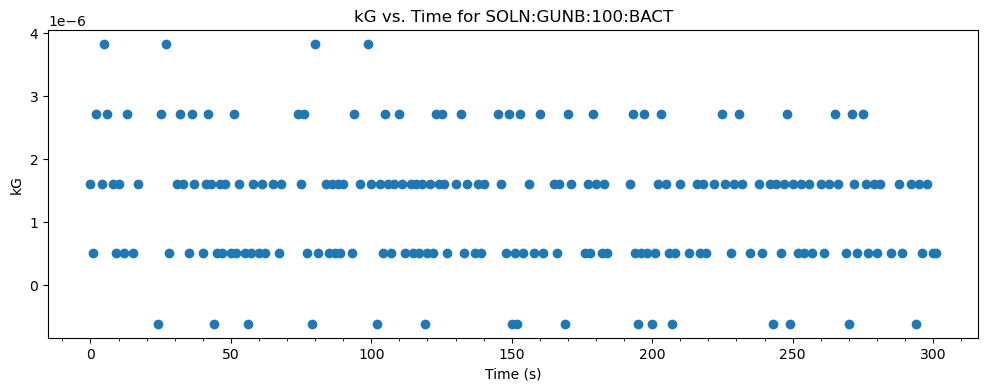

In [27]:
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(12, 4))

print(f"Normal element to total ratio: {get_non_na_ratio(soln_gunb_100_df_5m, "SOLN:GUNB:100:BACT")}") # get normal/total ratio
print(soln_gunb_100_df_5m.head(-10))
soln_gunb_100_df_5m_rows = remove_irrelevant_dates(soln_gunb_100_df_5m) # remove irrelevant rows
soln_gunb_100_df_5m_cols = remove_nan_from_col(soln_gunb_100_df_5m_rows, "SOLN:GUNB:100:BACT") # remove unwanted columns
soln_gunb_100_df_5m_plot = remove_date(soln_gunb_100_df_5m_cols) # modify timestamp text to only include the hour, min, and sec

ax.scatter(soln_gunb_100_df_5m_plot["Timestamp"], soln_gunb_100_df_5m_plot["SOLN:GUNB:100:BACT"])

# x label is always in seconds, but y label must be specified by the user as it is not given in the csv file
ax.set_xlabel("Time (s)")
ax.set_ylabel("kG")
ax.set_title("kG vs. Time for SOLN:GUNB:100:BACT")

ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())

### Part 3: Defining Plotting Functions  

These functions work on csvs that were downloaded, imported, and converted to DataFrames from the Archive Viewer website. 

Generating plots: 
1. `specific_col_plot` Plot of a specific column
2. `megaplot_all_cols` Megaplot of all the columns from the dataframe

Generating correlations: 

3. `spec_correl` Plot of a specific correlation between two specific dataframes and their specified columns
4. `correl_y` Plot a correlation between a specific column from a df (y-axis) and all the columns in the other df (x-axis)
5. `correl_x` Plot a correlation between a specific column from a df (x-axis) and all the columns in the other df (y-axis)

NOTE: 
- These functions are not very object oriented, and they're not necessarily meant to be used outside of a jupyter notebook environment
- If needed, a more modular approach can be developed, and it could automate access to the online database through web scraping/automation bots

In [28]:
"""Grid plotter helper function for megaplots"""
def plot_mega(ax, df_name, y_axis_title, i, j, col_ind, start, end): 
    # df_rows = remove_irrelevant_dates(df_name) # remove irrelevant rows

    if col_ind >= len(df_name.columns): # ends execution of for loop if no more columns to render
        return
    
    df_cols = remove_nan_from_col(df_name, df_name.columns[col_ind]) # remove unwanted columns
    df_plot = remove_date(df_cols) # modify timestamp text to only include the hour, min, and sec

    ax[i, j].scatter(df_plot.loc[start:end, ["Timestamp"]]["Timestamp"], df_plot.loc[start:end, [df_name.columns[col_ind]]][df_name.columns[col_ind]], s=10)
    ax[i, j].xaxis.set_major_locator(ticker.LinearLocator(3))
    ax[i, j].xaxis.set_minor_locator(ticker.LinearLocator(0))
    ax[i, j].tick_params(axis='y', which='major', labelsize=8)
    ax[i, j].tick_params(axis='x', which='major', labelsize=8)
    ax[i, j].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    # x label is always in seconds, but y label must be specified by the user as it is not given in the csv file
    ax[i, j].set_xlabel("Time (s)")
    ax[i, j].set_ylabel(y_axis_title)
    ax[i, j].set_title(f"{y_axis_title} vs. Time for {df_name.columns[col_ind]}", {'fontsize': 7})

"""Plot of a specific column in a df"""
def specific_col_plot(df_name, col_name, y_axis_title, start, end): 
    fig, ax = plt.subplots(figsize=(12, 4))
    print(f"Normal element to total ratio: {get_non_na_ratio(df_name, col_name)}") # get normal/total ratio
    # df_rows = remove_irrelevant_dates(df_name) # remove irrelevant rows
    df_cols = remove_nan_from_col(df_name, col_name) # remove unwanted columns
    df_plot = remove_date(df_cols) # modify timestamp text to only include the hour, min, and sec

    ax.scatter(df_plot.loc[start:end, ["Timestamp"]]["Timestamp"], df_plot.loc[start:end, [col_name]][col_name])

    # x label is always in seconds, but y label must be specified by the user as it is not given in the csv file
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(y_axis_title)
    ax.set_title(f"{y_axis_title} vs. Time for {col_name}")

    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())

"""Megaplot of all the columns from the df"""
def megaplot_all_cols(df_name, y_axis_title, start, end): 
    # want to create a grid of subplots
    col_len = len(df_name.columns) - 1
    dim = int(np.sqrt(col_len))
    # the following two lines are subject to change with increasing dimension
    fig, ax = plt.subplots(dim + 1, dim, figsize=(17, 15))
    plt.subplots_adjust(wspace=0.4, hspace=1)
    col_ind = 1 # track index of the columns in the df that will be cleaned in the for loop
    for i in range(0, dim + 1): 
        for j in range(0, dim):
            plot_mega(ax, df_name, y_axis_title, i, j, col_ind, start, end)
            col_ind += 1 # keep track of which column is being plotted


In [29]:
"""Plot of a specific correlation between two specific dataframes and their specified columns"""
def spec_correl(df_x, df_y, df_col_x, df_col_y, start, end): 
    # clean both dfs
    df_plot_x = clean_df(df_x, df_col_x)
    df_plot_y = clean_df(df_y, df_col_y)
    # plot dfs
    fig, ax = plt.subplots(figsize=(12, 4))
    print(f"Normal element to total ratio x: {get_non_na_ratio(df_x, df_col_x)}") # get normal/total ratio
    print(f"Normal element to total ratio y: {get_non_na_ratio(df_y, df_col_y)}") 
    ax.scatter(df_plot_x.loc[start:end, [df_col_x]][df_col_x], df_plot_y.loc[start:end, [df_col_y]][df_col_y]) # must specify indices to plot
    # x label is always in seconds, but y label must be specified by the user as it is not given in the csv file
    ax.set_xlabel(df_col_x)
    ax.set_ylabel(df_col_y)
    ax.set_title(f"{df_col_y} vs. {df_col_x}")
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())

"""Plot a correlation between a specific column from a df and all the columns in the other df"""
def correl(df_y, df_y_col, df_x, start, end): 
    # want to create a grid of subplots
    col_len = len(df_x.columns) - 1
    dim = int(np.sqrt(col_len))
    # the following two lines are subject to change with increasing dimension
    fig, ax = plt.subplots(dim + 1, dim, figsize=(17, 15))
    plt.subplots_adjust(wspace=0.4, hspace=1)
    col_ind = 1 # track index of the columns in the df that will be cleaned in the for loop
    for i in range(0, dim + 1): 
        for j in range(0, dim):
            if col_ind >= len(df_x.columns): 
                break
            plot_correl_mega(ax, df_y, df_y_col, df_x, i, j, col_ind, start, end)

            col_ind += 1 # keep track of which column is being plotted

"""Helper function to clean df"""
def clean_df(df, col): 
    df_cols = remove_nan_from_col(df, col) # df with only the one specified col df_col_x
    return remove_date(df_cols) # modify timestamp text to only include the hour, min, and sec

"""Helper function to clean both dfs"""
def clean_df_both(df_1, df_2, col_1, col_2): 
    df1_copy = df_1.copy()
    df2_copy = df_2.copy()
    df1_clean = remove_nan_from_col(df1_copy, col_1)
    df2_clean = remove_nan_from_col(df2_copy, col_2)   
    # merge only when Timestamp values match
    # citation: https://www.shanelynn.ie/merge-join-dataframes-python-pandas-index-1/
    result = pd.merge(df1_clean, df2_clean[["Timestamp", col_2]], on='Timestamp')
    return result

"""Helper function for correlation megaplots"""
def plot_correl_mega(ax, df_y, df_y_col, df_x, i, j, col_ind, start, end): 

    # want to clean both dfs simultaneously, so that only non-NaN rows are maintained

    df_plot = clean_df_both(df_y, df_x, df_y_col, df_x.columns[col_ind])

    if df_y_col == df_x.columns[col_ind]: 
        ax[i, j].scatter(df_plot.loc[start:end, [f"{df_y_col}_y"]][f"{df_y_col}_y"], 
                        df_plot.loc[start:end, [f"{df_x.columns[col_ind]}_x"]][f"{df_x.columns[col_ind]}_x"], s=10)
    else: 
        ax[i, j].scatter(df_plot.loc[start:end, [df_y_col]][df_y_col], 
                        df_plot.loc[start:end, [df_x.columns[col_ind]]][df_x.columns[col_ind]], s=10)

    ax[i, j].xaxis.set_major_locator(ticker.LinearLocator(3))
    ax[i, j].xaxis.set_minor_locator(ticker.LinearLocator(0))
    ax[i, j].tick_params(axis='y', which='major', labelsize=8)
    ax[i, j].tick_params(axis='x', which='major', labelsize=8)
    ax[i, j].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    # x label is always in seconds, but y label must be specified by the user as it is not given in the csv file
    ax[i, j].set_xlabel(df_x.columns[col_ind])
    ax[i, j].set_ylabel(df_y_col)
    ax[i, j].set_title(f"{df_y_col} vs. {df_x.columns[col_ind]}", {'fontsize': 7})

### Part 4: Isolating Peaks

For some PVs, rather than continual, steady oscillation, there are clear peaks in data points. We want to isolate these and only return those data points before plotting these columns and their correlations. 

Normal element to total ratio: 1.0


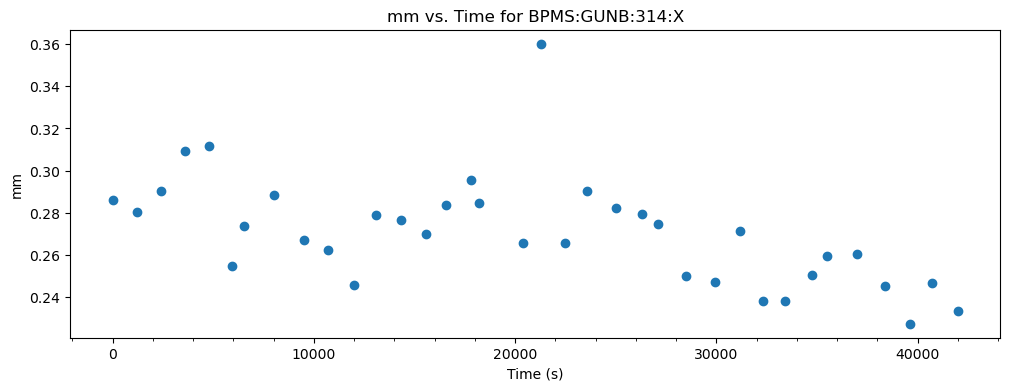

In [30]:
bpms_gunb_314_x = pd.read_csv("2w-bpms-gunb-314-x.csv")
specific_col_plot(bpms_gunb_314_x, "BPMS:GUNB:314:X", "mm", 0, 35) # plot the first 35 entries

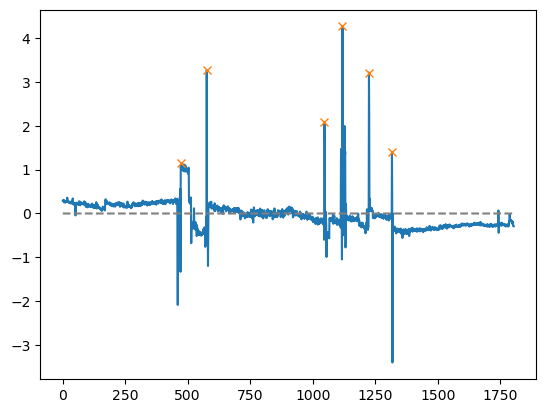

In [31]:
from scipy.signal import find_peaks

# peak finding example
x = bpms_gunb_314_x["BPMS:GUNB:314:X"]
all_peaks, peak_heights = find_peaks(x, height=1, distance=50)
plt.plot(x)
plt.plot(all_peaks, x[all_peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [32]:
"""plot and return dictionary of indices/peak heights for a df, specified columns, specified x range, and peak parameters"""
def plot_return_peaks_ts(df_name, x_col, y_col, y_label, peak_height, peak_dist, x_start, x_end):
    # plot peaks based on parameters
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    plt.subplots_adjust(wspace=0.4, hspace=0.3)
    y = df_name.loc[x_start:x_end, [y_col]][y_col]
    all_peaks, peak_heights = find_peaks(y, height=peak_height, distance=peak_dist)
    ax[0].plot(df_name.loc[x_start:x_end, [x_col]][x_col], y) 
    ax[0].plot(all_peaks, y[all_peaks], "x")
    ax[0].plot(np.zeros_like(y), "--", color="gray")
    # plot only peak points with x axis showing index corresponding to the returned dict
    ax[1].scatter(all_peaks, y[all_peaks])
    # match limits with the first plot
    ax[1].set_xlim(0, len(df_name.loc[x_start:x_end, [x_col]][x_col]))
    ax[1].set_ylim(-max(peak_heights["peak_heights"].tolist())*1.1, max(peak_heights["peak_heights"].tolist())*1.1)
    # set labels
    for i in range(2): 
        ax[i].set_xlabel(x_col)
        ax[i].set_ylabel(y_label)
        ax[i].xaxis.set_major_locator(ticker.LinearLocator(5))
        ax[i].set_title(f"{y_label} vs. Time for {y_col}")
    plt.show()
    result = {all_peaks.tolist()[i]: peak_heights["peak_heights"].tolist()[i] for i in range(len(all_peaks))}
    return result

[ 475  490  504  576 1047 1119 1130 1225 1317]


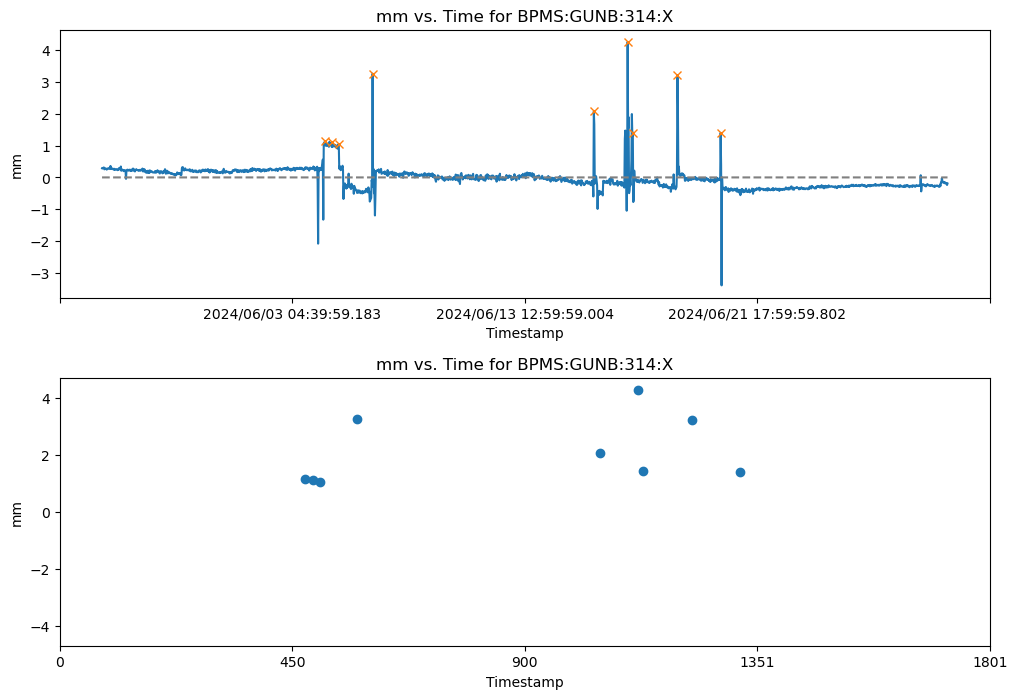

{475: 1.142504096031189,
 490: 1.101293921470642,
 504: 1.045462965965271,
 576: 3.2652273178100586,
 1047: 2.076930284500122,
 1119: 4.263757228851318,
 1130: 1.4122341871261597,
 1225: 3.2140984535217285,
 1317: 1.4024864435195925}

In [33]:
plot_return_peaks_ts(bpms_gunb_314_x, "Timestamp", "BPMS:GUNB:314:X", "mm", peak_height=1, peak_dist=10, x_start=0, x_end=1800)

### Part 5: Example Plots

The following plots are simple tests, and more can be generated as needed when testing the visual viewer's results in comparison to what can be achieved with MEME or the archive script from lcls-tools.

Normal element to total ratio: 0.392


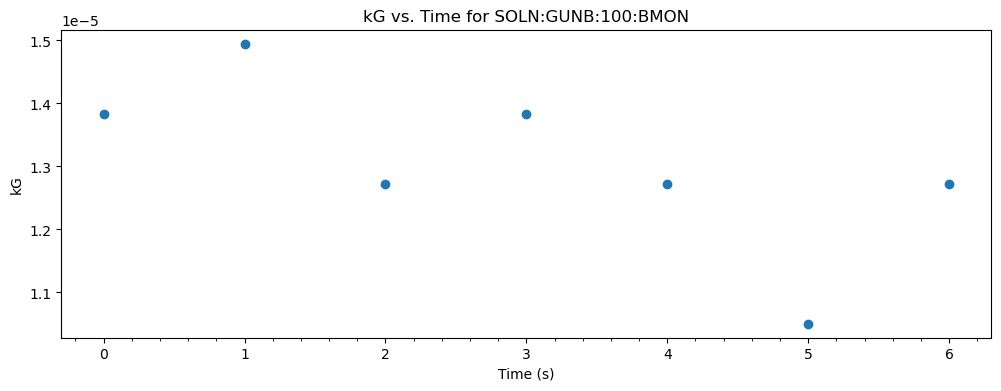

In [34]:
specific_col_plot(soln_gunb_100_df_1m, "SOLN:GUNB:100:BMON", "kG", 0, 30)

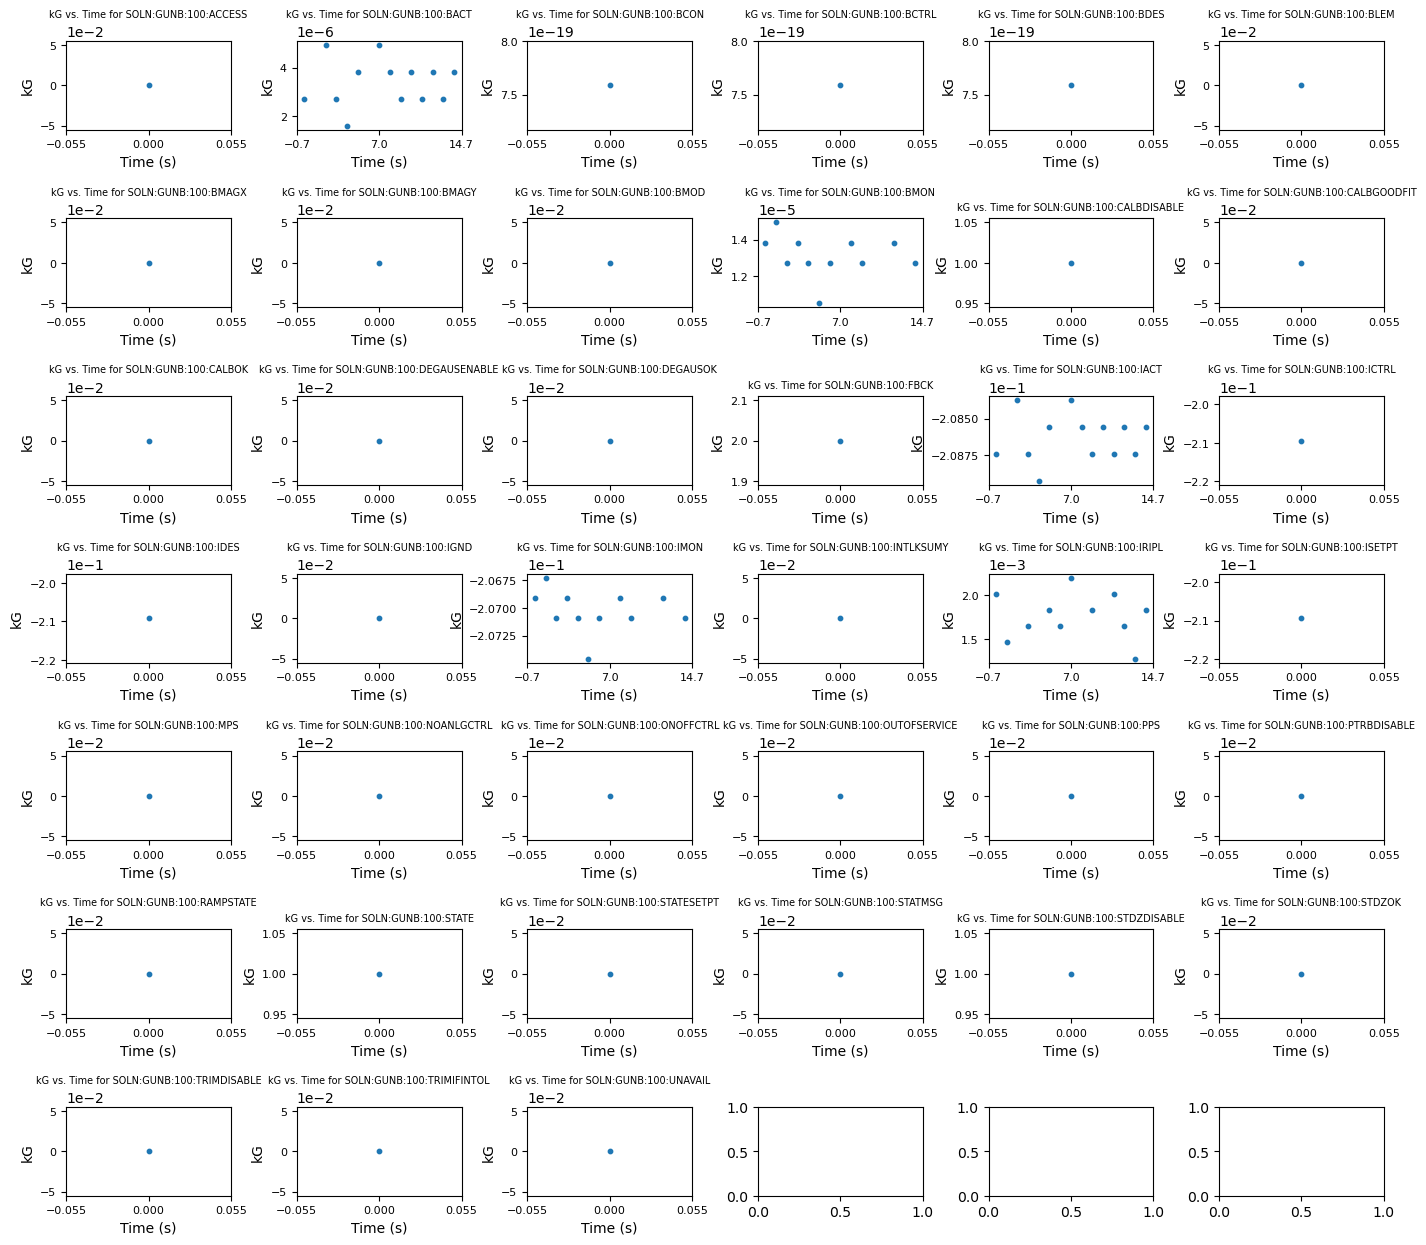

In [35]:
megaplot_all_cols(soln_gunb_100_df_1m, "kG", 0, 45)

Normal element to total ratio x: 0.392
Normal element to total ratio y: 0.392


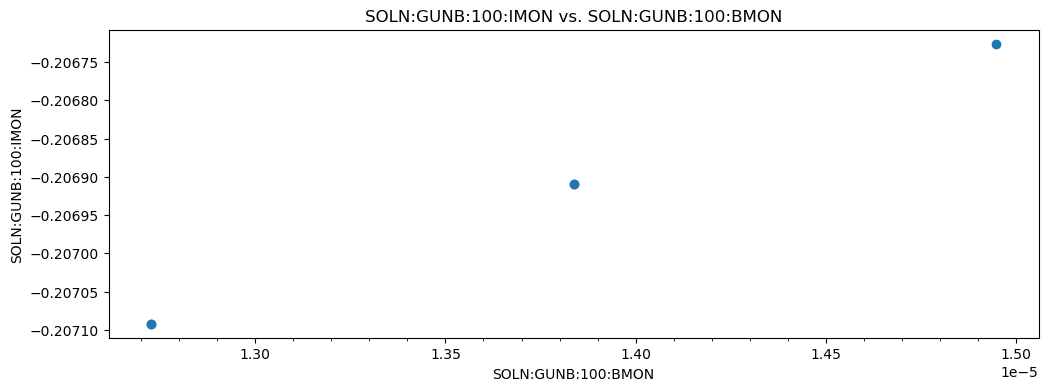

In [36]:
spec_correl(soln_gunb_100_df_1m, soln_gunb_100_df_1m, "SOLN:GUNB:100:BMON", "SOLN:GUNB:100:IMON", 0, 25)

### Part 6: Visualizing Corelations between BPM, HOM PVs, and other components in the beamline frontend

First, we can start by visualizing all of the components in a megaplot.

Then we will compare the BPMs and HOM PVs with the other components in their respective megaplots.

**BPM and HOM PVs**
- BPMS:GUNB:925:X
- BPMS:GUNB:925:Y
- BPMS:L0B:0183:FW:X_SLOW
- BPMS:L0B:0183:FW:Y_SLOW
- BPMS:HTR:120:FW:X_SLOW
- BPMS:HTR:120:FW:Y_SLOW
- BPMS:GUNB:925:FW:X_SLOW
- BPMS:GUNB:925:FW:Y_SLOW

**Other PVs**
- SOLN:GUNB:100:BACT
- QUAD:GUNB:212:1:BACT
- SOLN:GUNB:212:BACT
- QUAD:GUNB:212:2:BACT
- XCOR:GUNB:293:BACT
- YCOR:GUNB:293:BACT
- TORO:GUNB:360:CHRG 
- XCOR:GUNB:388:BACT
- YCOR:GUNB:388:BACT
- XCOR:GUNB:513:BACT
- YCOR:GUNB:513:BACT
- XCOR:GUNB:713:BACT
- YCOR:GUNB:713:BACT
- QUAD:GUNB:823:1:BACT
- SOLN:GUNB:823:BACT
- QUAD:GUNB:823:2:BACT
- XCOR:GUNB:927:BACT
- YCOR:GUNB:927:BACT

Separate data by charge
1. for a specific charge, what's the behavior? (For HOM Signal, but also other correlations)
2. (?) if you have it separated by charge, can you make a plot: does the HOM signal increase with charge (with similar magnet settings, as a control)

Unfortunately, this is ridiculous to do entirely in the visual tool, unless I write a selenium bot to scrape the web, click on buttons, and create a csv, while I go to lunch or do something else. 

But even if this happens, there is no guarantee that the visual tool will render everything on the screen. Sure, the visualizer says that it has added the PV to the dataset. But if there is no plotted curve, it will not be saved to the csv when everything is downloaded. Therefore, while the selenium bot may work in theory, there are issues with the the website itself that need to be resolved first. 

Ideally, it would be nice to do a bulk download of a list of PVs that you could simply paste into the website, and then you could set the timeframe and download it all as a csv file. However, the more practical option is to simply use a tool like the lcls-tools archiver.py or MEME. 

As a proof of concept, I'll render a subset in this notebook: 

**BPM and HOM PVs**
- BPMS:L0B:0183:FW:X_SLOW
- BPMS:HTR:120:FW:X_SLOW
- BPMS:GUNB:925:FW:X_SLOW

**Other PVs**
- SOLN:GUNB:100:BACT
- TORO:GUNB:360:CHRG 
- QUAD:GUNB:823:1:BACT

,Timestamp,BPMS:L0B:0183:FW:X_SLOW,BPMS:HTR:120:FW:X_SLOW,BPMS:GUNB:925:FW:X_SLOW,SOLN:GUNB:100:BACT,TORO:GUNB:360:CHRG,TORO:GUNB:360:CHRG.1,QUAD:GUNB:823:1:BACT
0,2024/06/14 17:09:51.653,NaN,NaN,NaN,NaN,NaN,NaN,0.001533
1,2024/06/14 17:09:55.099,NaN,NaN,NaN,NaN,11.970572,11.970572,NaN
2,2024/06/14 17:09:59.098,-0.019043,-0.155585,NaN,NaN,NaN,NaN,NaN
3,2024/06/14 17:09:59.294,NaN,NaN,0.121679,NaN,NaN,NaN,NaN
4,2024/06/14 17:09:59.644,NaN,NaN,NaN,2.720457e-06,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
9326,2024/06/28 17:14:28.779,NaN,NaN,NaN,NaN,59.696629,59.696629,NaN
9327,2024/06/28 17:14:29.269,NaN,NaN,0.135496,NaN,NaN,NaN,NaN
9328,2024/06/28 17:14:29.644,NaN,NaN,NaN,4.984367e-07,NaN,NaN,NaN
9329,2024/06/28 17:14:30.053,-0.005951,0.033453,NaN,NaN,NaN,NaN,NaN


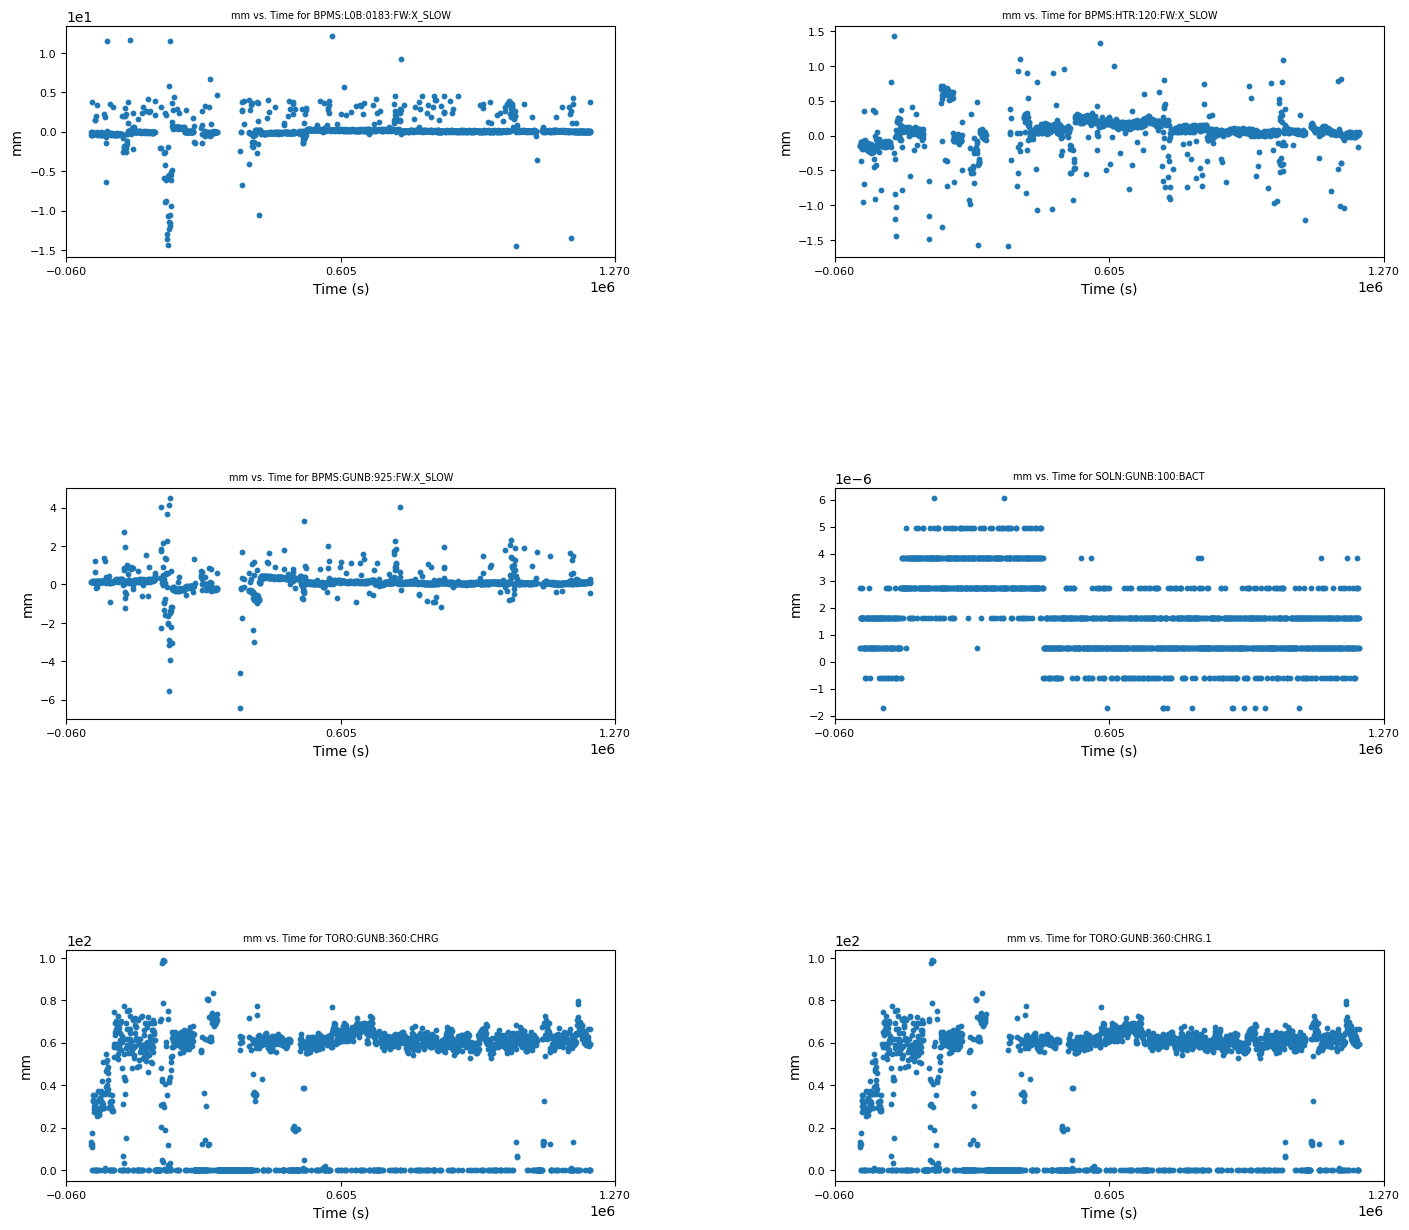

In [37]:
# Visualize all in megaplot
df_correl = pd.read_csv("correl-test.csv")
megaplot_all_cols(df_correl, "mm", start=0, end=10000)
df_correl

In [38]:
"""Helper function to clean both dfs"""
def clean_df_both(df_1, df_2, col_1, col_2): 
    df1_copy = df_1.copy()
    df2_copy = df_2.copy()
    df1_clean = remove_nan_from_col(df1_copy, col_1)
    df2_clean = remove_nan_from_col(df2_copy, col_2)   
    # merge only when Timestamp values match
    # citation: https://www.shanelynn.ie/merge-join-dataframes-python-pandas-index-1/
    result = pd.merge(df1_clean, df2_clean[["Timestamp", col_2]], on='Timestamp')
    return result

clean_df_both(df_correl, df_correl, "BPMS:L0B:0183:FW:X_SLOW", "BPMS:L0B:0183:FW:X_SLOW")

,Timestamp,BPMS:L0B:0183:FW:X_SLOW_x,BPMS:L0B:0183:FW:X_SLOW_y
0,2024/06/14 17:09:59.098,-0.019043,-0.019043
1,2024/06/14 17:19:59.152,-0.436203,-0.436203
2,2024/06/14 17:29:59.108,-0.346939,-0.346939
3,2024/06/14 17:39:59.162,0.041061,0.041061
4,2024/06/14 17:49:59.118,-0.338608,-0.338608
...,...,...,...
1735,2024/06/28 16:49:41.237,3.773483,3.773483
1736,2024/06/28 16:59:59.127,0.058319,0.058319
1737,2024/06/28 17:09:59.181,0.056534,0.056534
1738,2024/06/28 17:14:30.053,-0.005951,-0.005951


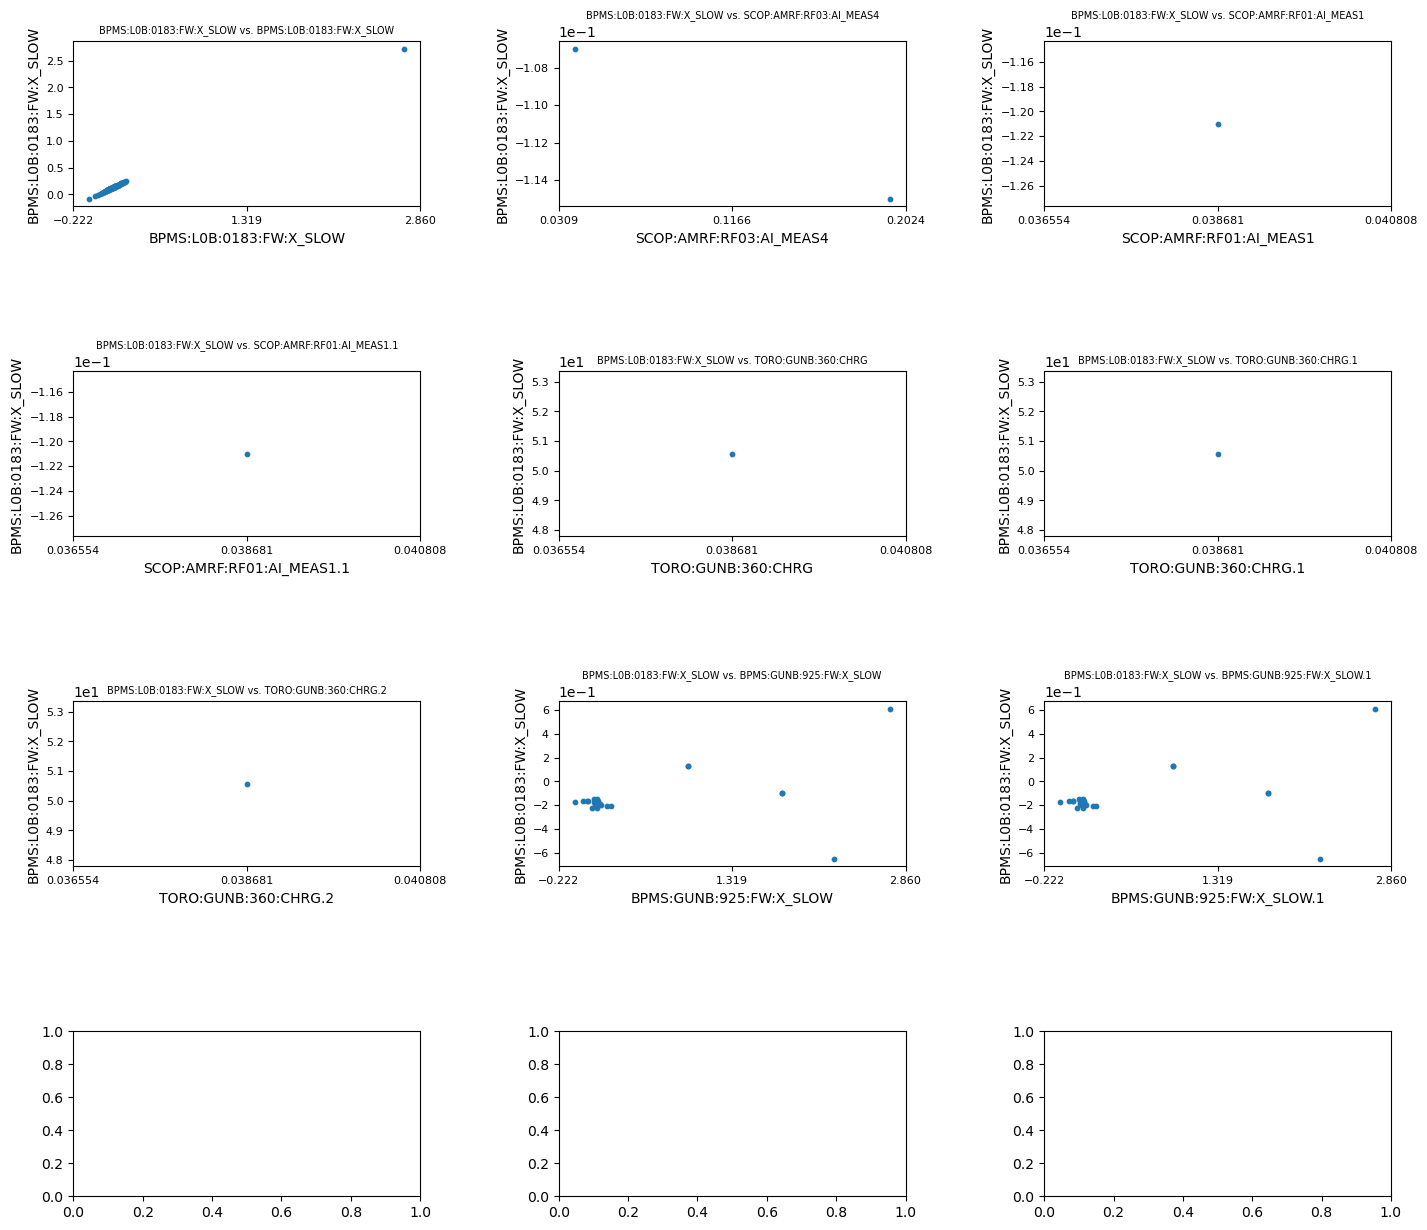

In [39]:
feb = pd.read_csv("/Users/jonathontordilla/Desktop/hombom24/archive-analysis/archviewer-plots/hom-data/feb_hom_with_charge.csv")
correl(feb, "BPMS:L0B:0183:FW:X_SLOW", feb, start=0, end=100)

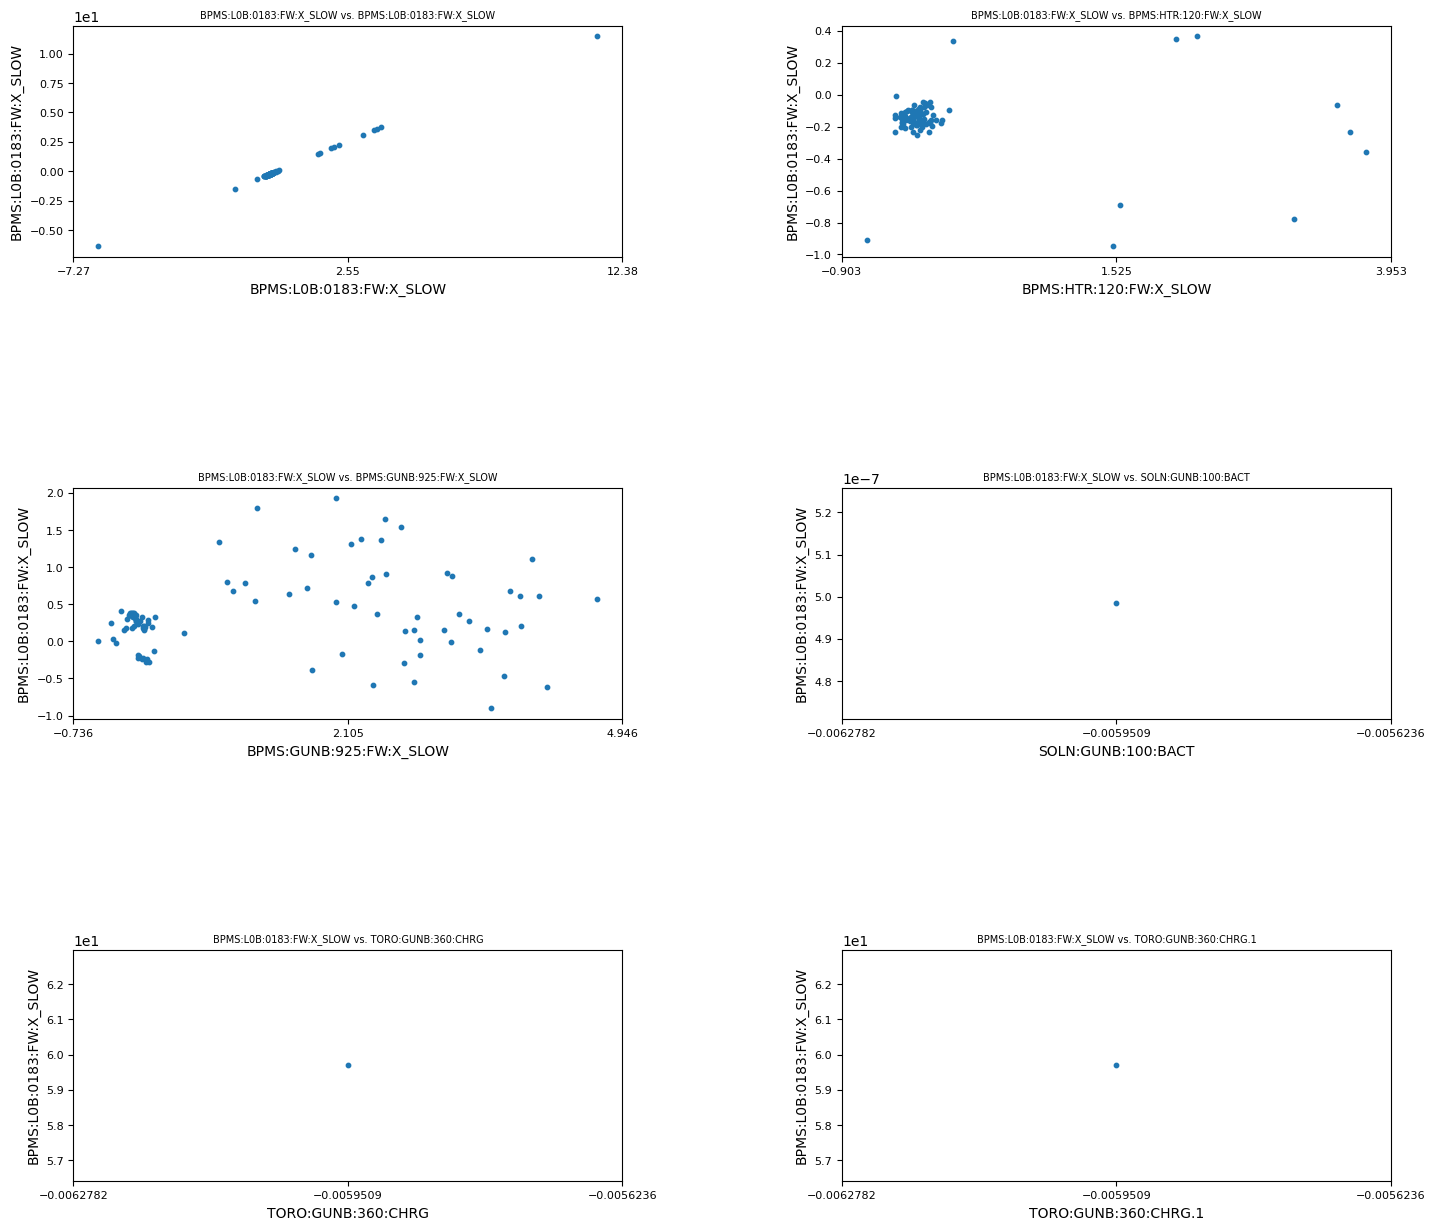

In [40]:
# BPMS:L0B:0183:FW:X_SLOW

correl(df_correl, "BPMS:L0B:0183:FW:X_SLOW", df_correl, start=0, end=100)

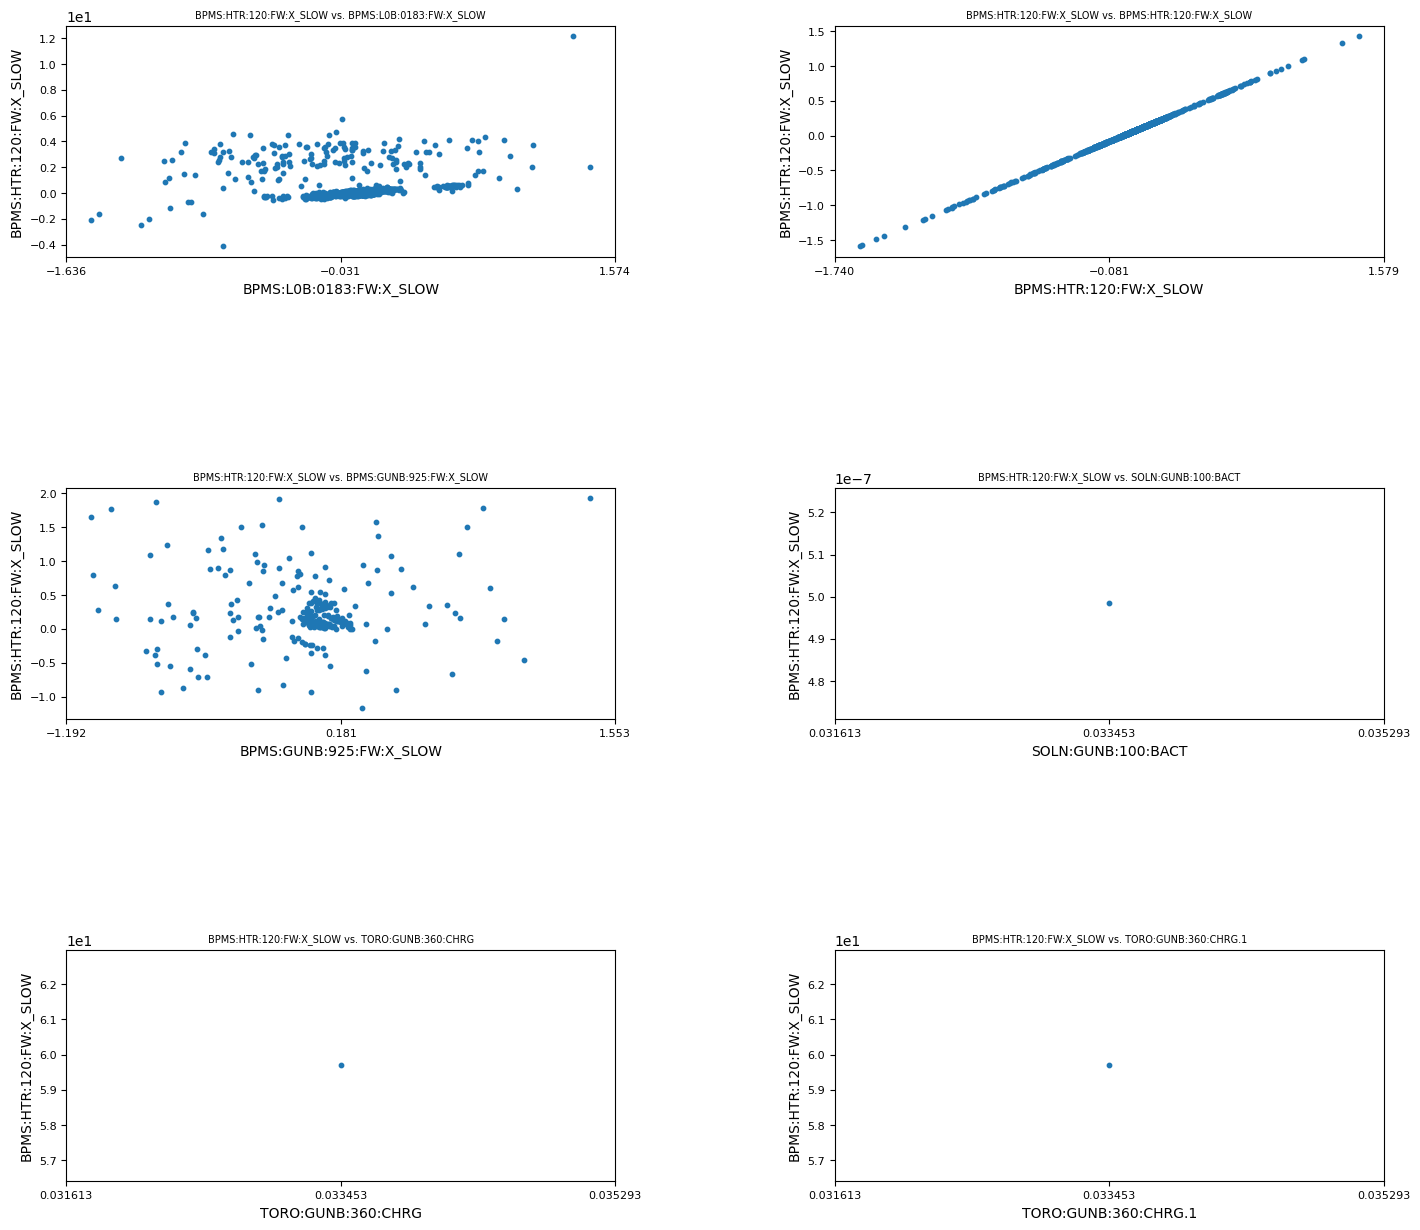

In [41]:
# BPMS:HTR:120:FW:X_SLOW

correl(df_correl, "BPMS:HTR:120:FW:X_SLOW", df_correl, start=0, end=10000)

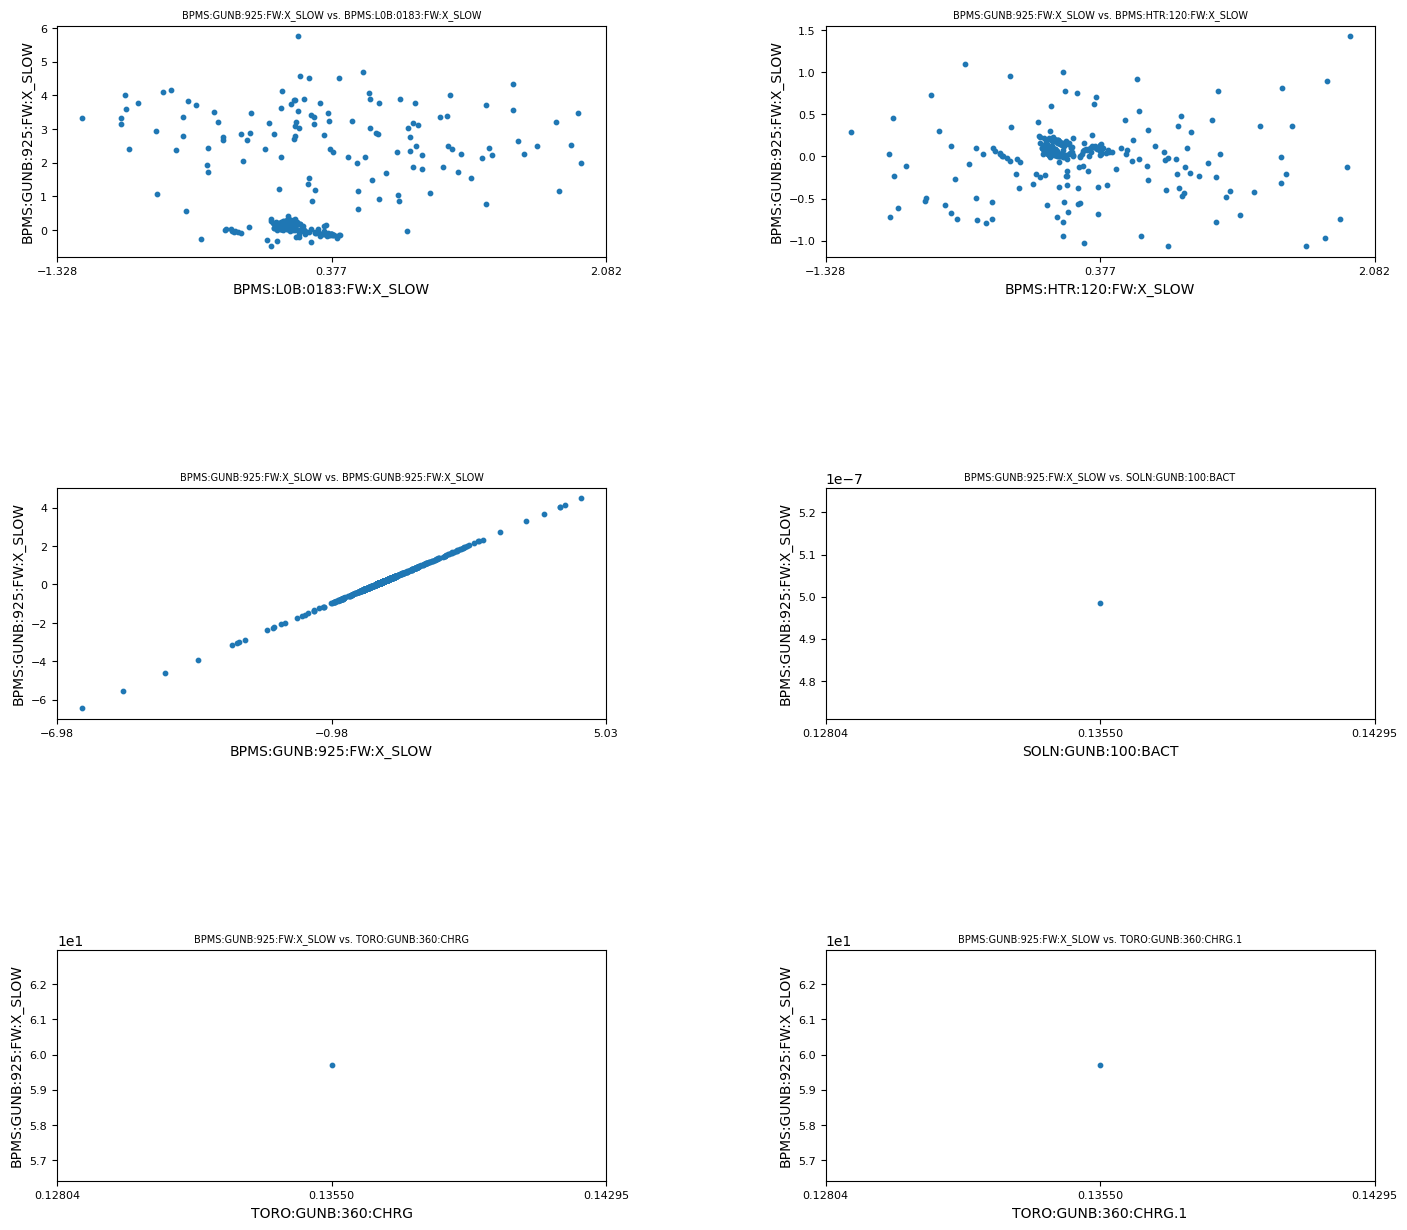

In [42]:
# BPMS:GUNB:925:FW:X_SLOW

correl(df_correl, "BPMS:GUNB:925:FW:X_SLOW", df_correl, start=0, end=10000)

### Next Steps

Although now we have useful functions that can be used to draw correlations between different components along the beamline, it is still cumbersome to go to the visual tool, click on several buttons, download the files, convert them to dataframes, and then feed them into functions. 

A future extension can be to write a selenium python bot to automatically search for a PV, select a timeframe, download the file, and convert it to a dataframe. This can then be applied to the various other existing functions. 

This would involve adding all the desired PVs, specifying a start and end time, and downloading the file as a csv.